In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
import random
import gc
import os
import datetime
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

today = datetime.datetime.now().strftime('%Y%m%d')

pd.set_option('max_rows', 9999)
pd.set_option('max_columns', 9999)

Half_Half_CatBoost Training

In [2]:
class Trainer:
    def __init__(self, importance_df, model_type='lgb', use_feature_num=None):
        self.model_type = model_type
        
        if use_feature_num is not None:
            self.features = importance_df['feature'][:use_feature_num].tolist()
        else:
            self.features = None
            
    def train_half(self, X_train, y_train, params, num_boost_round, early_stopping_rounds, verbose=200):
        
        if self.features is None:
            self.features = X_train.columns
            
        self.features = [c for c in self.features if c not in ['M']]
            
        self.X_train = X_train[self.features]
        self.y_train = y_train
        
        if self.model_type == 'lgb':
            print('LightGBM Model Creating...')
            d_half_1 = lgb.Dataset(self.X_train[:int(self.X_train.shape[0] / 2)], 
                                   label=self.y_train[:int(X_train.shape[0] / 2)])
            d_half_2 = lgb.Dataset(self.X_train[int(self.X_train.shape[0] / 2):], 
                                   label=self.y_train[int(X_train.shape[0] / 2):])

            print("Building model with first half and validating on second half:")
            self.model_1 = lgb.train(params, train_set=d_half_1, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_1, d_half_2], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
            print('')
            print("Building model with second half and validating on first half:")
            self.model_2 = lgb.train(params, train_set=d_half_2, num_boost_round=num_boost_round, 
                                     valid_sets=[d_half_2, d_half_1], verbose_eval=verbose, 
                                     early_stopping_rounds=early_stopping_rounds)
            
        elif self.model_type == 'cat':
            print('CatBoost Model Creating...')
            cat_features_index = np.where(self.X_train.dtypes == 'category')[0]
            d_half_1 = Pool(self.X_train[:int(self.X_train.shape[0] / 2)], 
                            label=self.y_train[:int(X_train.shape[0] / 2)],
                            cat_features=cat_features_index)
            d_half_2 = Pool(self.X_train[int(self.X_train.shape[0] / 2):], 
                            label=self.y_train[int(X_train.shape[0] / 2):],
                            cat_features=cat_features_index)
            
            params['iterations'] = num_boost_round
            print("Building model with first half and validating on second half:")
            self.model_1 = CatBoostRegressor(**params)
            self.model_1.fit(d_half_1, eval_set=d_half_2, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
            print('')
            print("Building model with second half and validating on first half:")
            self.model_2 = CatBoostRegressor(**params)
            self.model_2.fit(d_half_2, eval_set=d_half_1, use_best_model=True,
                        early_stopping_rounds=early_stopping_rounds,
                        verbose=verbose)
            
        
        return (self.model_1, self.model_2)
    
    def get_feature_importance(self):
        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_1["importance"] = self.model_1.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_1["importance"] = self.model_1.get_feature_importance()
        df_fimp_1["half"] = 1

        df_fimp_2 = pd.DataFrame()
        df_fimp_2["feature"] = self.X_train.columns.values
        if self.model_type == 'lgb':
            df_fimp_2["importance"] = self.model_2.feature_importance()
        elif self.model_type == 'cat':
            df_fimp_2["importance"] = self.model_2.get_feature_importance()
        df_fimp_2["half"] = 2

        df_fimp = pd.concat([df_fimp_1, df_fimp_2], axis=0)

        plt.figure(figsize=(14, int(len(self.X_train.columns) * 0.3)), facecolor='w')
        sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
        plt.title("CatBoost Feature Importance")
        plt.tight_layout()
        plt.show()
        
        del df_fimp_1, df_fimp_2, df_fimp
        gc.collect()

In [3]:
# config - CatBoost
train_pkl_path = '../input/prep_train_20191118.pkl'
test_pkl_path = '../input/prep_test_20191118.pkl'
importance_path = '../Importance/importance_20191118.csv'
model_type = 'cat'

params = {
    'learning_rate': 0.2,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',
    'random_seed': 42,
    'metric_period': 10,
    'task_type': 'GPU',
    'depth': 8,
    }

num_boost_round = 5000
early_stopping_rounds = 50
num_feature = 30
verbose = 10

In [4]:
%%time
# Training
# Data Loading
with open(train_pkl_path, 'rb') as f:
    train = pickle.load(f)

importance_df = pd.read_csv(importance_path)
# Train Model
trainer = Trainer(importance_df=importance_df, model_type=model_type, use_feature_num=num_feature)
models = trainer.train_half(train[0], train[1], params, num_boost_round, early_stopping_rounds, verbose)

del train, importance_df
gc.collect()

with open(f'../Model/model_{today}_{trainer.model_type}_half.pkl', 'wb') as f:
    pickle.dump(models, f, protocol=4)

CatBoost Model Creating...
Building model with first half and validating on second half:
0:	learn: 1.8622536	test: 1.8715138	best: 1.8715138 (0)	total: 1.32s	remaining: 1h 50m 12s
10:	learn: 1.2042169	test: 1.3491464	best: 1.3491464 (10)	total: 15.7s	remaining: 1h 58m 28s
20:	learn: 1.1221547	test: 1.2949159	best: 1.2949159 (20)	total: 29s	remaining: 1h 54m 43s
30:	learn: 1.0808984	test: 1.2752895	best: 1.2752895 (30)	total: 42.8s	remaining: 1h 54m 24s
40:	learn: 1.0502876	test: 1.2661738	best: 1.2645974 (39)	total: 56.6s	remaining: 1h 54m 9s
50:	learn: 1.0275786	test: 1.2576084	best: 1.2561018 (48)	total: 1m 11s	remaining: 1h 55m 30s
60:	learn: 1.0063694	test: 1.2478171	best: 1.2478171 (60)	total: 1m 27s	remaining: 1h 58m 23s
70:	learn: 0.9878811	test: 1.2457145	best: 1.2457145 (70)	total: 1m 43s	remaining: 1h 59m 12s
80:	learn: 0.9740204	test: 1.2376162	best: 1.2376162 (80)	total: 1m 58s	remaining: 1h 59m 34s
90:	learn: 0.9603594	test: 1.2353070	best: 1.2347004 (87)	total: 2m 13s	rem

280:	learn: 0.8498123	test: 1.2001274	best: 1.1996971 (239)	total: 7m 9s	remaining: 2h 9s
290:	learn: 0.8464310	test: 1.1993132	best: 1.1993132 (290)	total: 7m 23s	remaining: 1h 59m 40s
300:	learn: 0.8426164	test: 1.1992704	best: 1.1989423 (298)	total: 7m 38s	remaining: 1h 59m 23s
310:	learn: 0.8385461	test: 1.1989870	best: 1.1988878 (305)	total: 7m 56s	remaining: 1h 59m 39s
320:	learn: 0.8351750	test: 1.1979399	best: 1.1979399 (320)	total: 8m 12s	remaining: 1h 59m 40s
330:	learn: 0.8323009	test: 1.1969623	best: 1.1969623 (330)	total: 8m 29s	remaining: 1h 59m 46s
340:	learn: 0.8296955	test: 1.1961017	best: 1.1961017 (340)	total: 8m 44s	remaining: 1h 59m 22s
350:	learn: 0.8273266	test: 1.1957509	best: 1.1955040 (347)	total: 8m 59s	remaining: 1h 59m 10s
360:	learn: 0.8247196	test: 1.1958068	best: 1.1952763 (354)	total: 9m 15s	remaining: 1h 59m 1s
370:	learn: 0.8220699	test: 1.1956590	best: 1.1952763 (354)	total: 9m 31s	remaining: 1h 58m 46s
380:	learn: 0.8192633	test: 1.1953658	best: 1.1

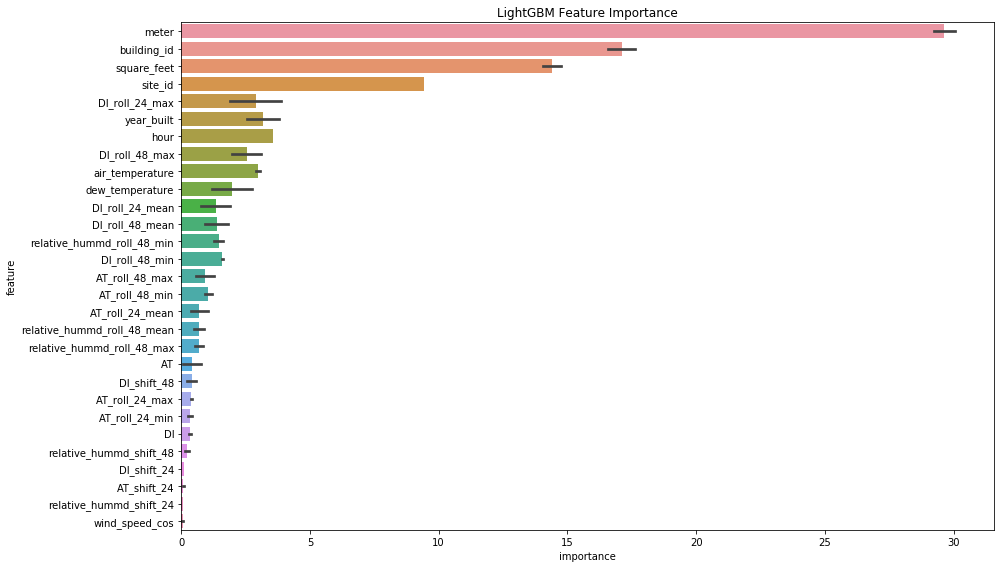

In [5]:
trainer.get_feature_importance()

Preparing test data 

Preparing test data with same features as train data.

In [6]:
%%time
# Predict & Submission

# Data Loading
with open(test_pkl_path, 'rb') as f:
    test = pickle.load(f)
    
X_test = test[0]
row_id = test[1]
del test
gc.collect()
    
if num_feature is not None:
    X_test = X_test[trainer.features]
    gc.collect()

# Set Predict values
pred = np.zeros(len(row_id))

# Prediction
for model in models:
    if trainer.model_type == 'lgb':
        pred += np.expm1(model.predict(X_test, num_iteration=model.best_iteration)) / int(len(models))
    elif trainer.model_type == 'cat':
        pred += np.expm1(model.predict(X_test)) / int(len(models))
    
today = datetime.datetime.now().strftime('%Y%m%d')
submission = pd.DataFrame({"row_id": row_id, "meter_reading": np.clip(pred, 0, a_max=None)})
submission.to_csv(f"../Output/submission_from_nb_{trainer.model_type}_{today}.csv", index=False)
print("DONE")

DONE
Wall time: 15min 10s
